# ML Model Experimentation and Selection
In this notebook, we will test out three different models (XGBoost vs ANN vs Random Forest). We will compare the results of these models based on MSE, MAE, R^2 evaluation metrics to find the best model for predicting housing prices.

In [38]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [5]:
# Import dataset 
private_data = "../datasets/cleaned/cleaned_private.csv"

df = pd.read_csv(private_data, quotechar='"', escapechar='\\', thousands=',')
df

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Street Name,Type of Sale,Type of Area,Property Type,Number of Units,...,x,y,longitude,latitude,Price,Sale Year,Lease Duration,Lease Start Year,Remaining Lease Years,Distance to MRT (km)
0,ONE BERNAM,2088000,807.30,2586,1/12/2022,BERNAM STREET,New Sale,Strata,Apartment,1,...,29153.70313,28484.03047,103.843685,1.273874,2088000,2022,99,2019.0,96,0.373974
1,RIVIERE,3390000,1140.98,2971,1/12/2022,JIAK KIM STREET,New Sale,Strata,Apartment,1,...,27806.97629,29703.14749,103.831584,1.284899,3390000,2022,99,2018.0,95,0.456742
2,RIVIERE,3780000,1216.33,3108,1/12/2022,JIAK KIM STREET,New Sale,Strata,Apartment,1,...,27806.97629,29703.14749,103.831584,1.284899,3780000,2022,99,2018.0,95,0.456742
3,LEEDON GREEN,1923000,710.42,2707,1/12/2022,LEEDON HEIGHTS,New Sale,Strata,Condominium,1,...,24686.58238,32814.07850,103.803546,1.313033,1923000,2022,999,2022.0,999,0.647571
4,LEEDON GREEN,1590000,538.20,2954,1/12/2022,LEEDON HEIGHTS,New Sale,Strata,Condominium,1,...,24686.58238,32814.07850,103.803546,1.313033,1590000,2022,999,2022.0,999,0.647571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128344,THE WHITLEY RESIDENCES,4998000,7190.35,695,1/3/2020,WHITLEY ROAD,Resale,Strata,Semi-Detached House,1,...,28451.19031,34188.12341,103.837373,1.325460,4998000,2020,999,NaN,999,0.907586
128345,WEST SHORE RESIDENCES,2850000,3982.68,716,1/3/2020,PASIR PANJANG ROAD,Resale,Strata,Terrace House,1,...,22606.54759,29305.33795,103.784856,1.281301,2850000,2020,999,NaN,999,0.327247
128346,ESTRIVILLAS,3180000,4703.87,676,1/3/2020,JALAN LIM TAI SEE,Resale,Strata,Semi-Detached House,1,...,23521.14721,33709.47320,103.793074,1.321131,3180000,2020,999,NaN,999,1.050407
128347,KEW RESIDENCIA,1570000,2142.04,733,1/3/2020,KEW CRESCENT,Resale,Strata,Terrace House,1,...,40819.06720,33358.41374,103.948504,1.317953,1570000,2020,99,1994.0,73,0.872140


# XGBoost Model

In [40]:
# Function to remove outliers for a numeric column
def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Preprocess data: Extract 'Sale Month-Year' from 'Sale Date'
df['Sale Month-Year'] = pd.to_datetime(df['Sale Date']).dt.to_period('M').astype(str)

# Apply outlier removal to numeric columns only
for col in ['Price', 'Area (SQFT)', 'Remaining Lease Years']:
    df = remove_outliers_iqr(df, col)

# Reset index after filtering
df.reset_index(drop=True, inplace=True)

# Select relevant columns
features = ['Area (SQFT)', 'Remaining Lease Years', 'Property Type', 'Postal District',
            'Type of Sale', 'Floor Level', 'Sale Month-Year',  'Distance to MRT (km)']
target = 'Price'

# Encode categorical features
df_encoded = df[features + [target]].copy()
categorical_cols = ['Property Type', 'Postal District', 'Type of Sale', 'Floor Level', 'Sale Month-Year']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Save if needed later

# Split into features and target
X = df_encoded[features]
y = df_encoded[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

# Train XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=40)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


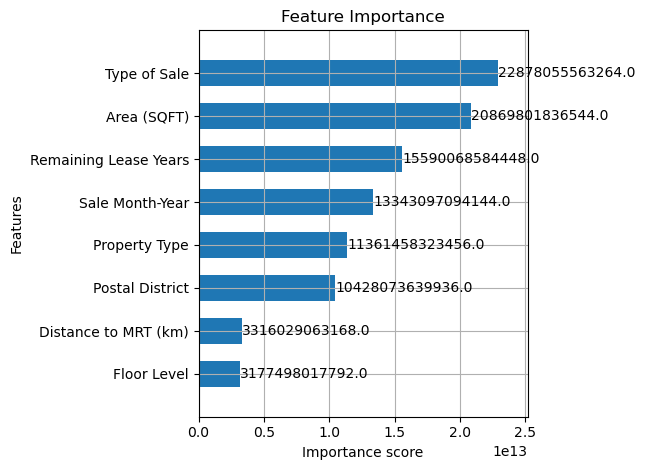

In [41]:
# Feature Importance Plot (which features XGBoost found most useful during training)
xgb.plot_importance(model, importance_type='gain', height=0.6)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

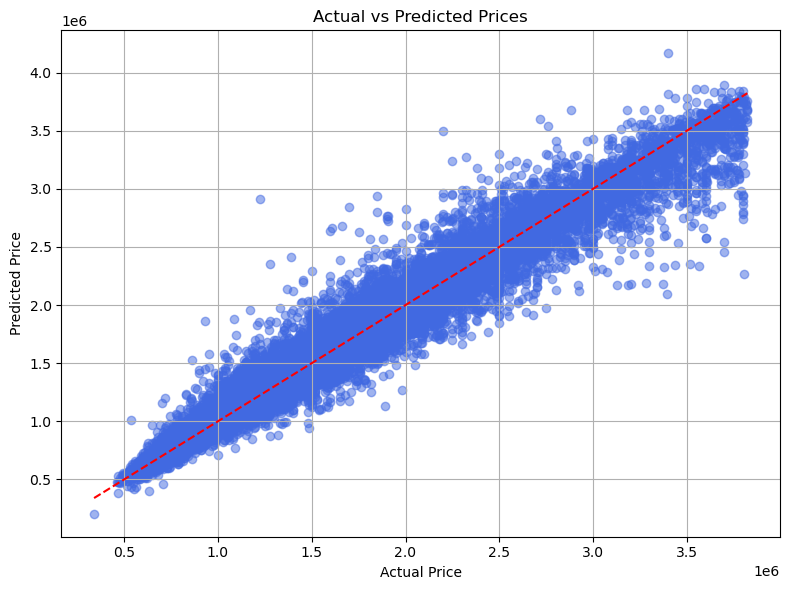

In [42]:
# Scatter Plot of Actual vs Predicted Prices (how close predictions are to the actual values)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
# Evaluate XGBoost model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error (MSE): 19218363841.98
Mean Absolute Error (MAE): 89197.91
R^2 Score: 0.9560


# ANN

In [44]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
df

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Street Name,Type of Sale,Type of Area,Property Type,Number of Units,...,y,longitude,latitude,Price,Sale Year,Lease Duration,Lease Start Year,Remaining Lease Years,Distance to MRT (km),Sale Month-Year
0,ONE BERNAM,2088000,807.30,2586,1/12/2022,BERNAM STREET,New Sale,Strata,Apartment,1,...,28484.03047,103.843685,1.273874,2088000,2022,99,2019.0,96,0.373974,2022-01
1,RIVIERE,3390000,1140.98,2971,1/12/2022,JIAK KIM STREET,New Sale,Strata,Apartment,1,...,29703.14749,103.831584,1.284899,3390000,2022,99,2018.0,95,0.456742,2022-01
2,RIVIERE,3780000,1216.33,3108,1/12/2022,JIAK KIM STREET,New Sale,Strata,Apartment,1,...,29703.14749,103.831584,1.284899,3780000,2022,99,2018.0,95,0.456742,2022-01
3,LEEDON GREEN,1923000,710.42,2707,1/12/2022,LEEDON HEIGHTS,New Sale,Strata,Condominium,1,...,32814.07850,103.803546,1.313033,1923000,2022,999,2022.0,999,0.647571,2022-01
4,LEEDON GREEN,1590000,538.20,2954,1/12/2022,LEEDON HEIGHTS,New Sale,Strata,Condominium,1,...,32814.07850,103.803546,1.313033,1590000,2022,999,2022.0,999,0.647571,2022-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113360,RIVERTREES RESIDENCES,1620000,1528.49,1060,1/9/2020,FERNVALE CLOSE,Resale,Strata,Terrace House,1,...,41733.07295,103.881107,1.393693,1620000,2020,99,2013.0,92,1.615196,2020-01
113361,LANDED HOUSING DEVELOPMENT,1900000,1765.30,1076,1/8/2020,UPPER EAST COAST ROAD,Resale,Strata,Terrace House,1,...,32850.78470,103.927394,1.313364,1900000,2020,999,NaN,999,0.472632,2020-01
113362,CEYLON COURT,1700000,1733.00,981,1/7/2020,CEYLON ROAD,Resale,Strata,Terrace House,1,...,32354.04889,103.899907,1.308872,1700000,2020,999,NaN,999,0.893489,2020-01
113363,LOYANG COURT,1250000,1915.99,652,1/5/2020,JALAN LOYANG BESAR,Resale,Strata,Terrace House,1,...,40072.29387,103.959445,1.378671,1250000,2020,99,1994.0,73,1.282191,2020-01


In [61]:
df_features=['Area (SQFT)', 'Remaining Lease Years', 'Property Type', 'Postal District',
            'Type of Sale', 'Floor Level', 'Sale Month-Year',  'Distance to MRT (km)']
X = df[df_features]
y = df['Price'].values
categorical_cols = ['Property Type', 'Postal District', 'Type of Sale', 'Floor Level', 'Sale Month-Year']
numerical_cols = ['Area (SQFT)', 'Remaining Lease Years', 'Distance to MRT (km)' ]

X_encoded = pd.get_dummies(X[categorical_cols], drop_first=True)
X_final = pd.concat([X[numerical_cols], X_encoded], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X_final, y, test_size=0.25, random_state=40)
print(x_train.shape) # split all categorical data into several columns with 1/0 for each column (att)
print(x_test.shape) 
print(y_train.shape)
print(y_test.shape)

(85023, 32)
(28342, 32)
(85023,)
(28342,)


In [52]:
#now we will create ANN model
model=Sequential()
model.add(Dense(9, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
model.fit(x_train,y_train,epochs=1000)

Epoch 1/1000
2657/2657 [==============================] - 3s 765us/step - loss: 742649036800.0000
Epoch 2/1000
2657/2657 [==============================] - 2s 737us/step - loss: 273607311360.0000
Epoch 3/1000
2657/2657 [==============================] - 2s 757us/step - loss: 271594946560.0000
Epoch 4/1000
2657/2657 [==============================] - 2s 752us/step - loss: 269464698880.0000
Epoch 5/1000
2657/2657 [==============================] - 2s 744us/step - loss: 267193057280.0000
Epoch 6/1000
2657/2657 [==============================] - 2s 750us/step - loss: 264840839168.0000
Epoch 7/1000
2657/2657 [==============================] - 2s 733us/step - loss: 262114672640.0000
Epoch 8/1000
2657/2657 [==============================] - 2s 720us/step - loss: 259064004608.0000
Epoch 9/1000
2657/2657 [==============================] - 2s 728us/step - loss: 255228248064.0000
Epoch 10/1000
2657/2657 [==============================] - 2s 730us/step - loss: 250536607744.0000
Epoch 11/1000
2657/

Text(0.5, 1.0, 'Training Loss per Epoch')

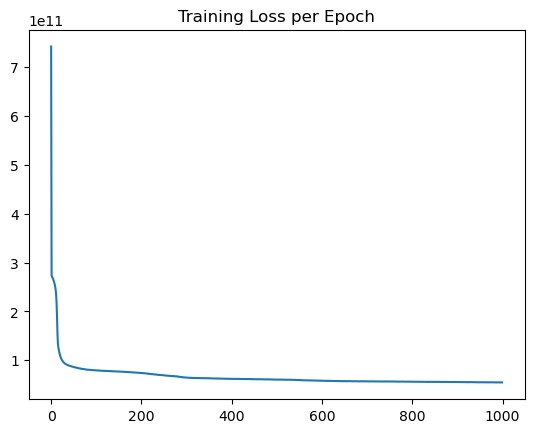

In [53]:

#model.history.history
loss = model.history.history['loss']
sns.lineplot(x=range(len(loss)),y=loss)
plt.title("Training Loss per Epoch")

In [54]:

#let's predict...
test_predictions = model.predict(X_test)

886/886 [==============================] - 2s 1ms/step


In [55]:

#let's plot our prediction verses actual
df_pred=pd.DataFrame({'test_actual': y_test})
df_pred['test_pred']=test_predictions
df_pred.head()

,test_actual,test_pred
0,780000,1087007.500
1,1575000,1778554.375
2,1380000,1318586.875
3,1850888,2092023.250
4,2222000,2933860.250


<Axes: >

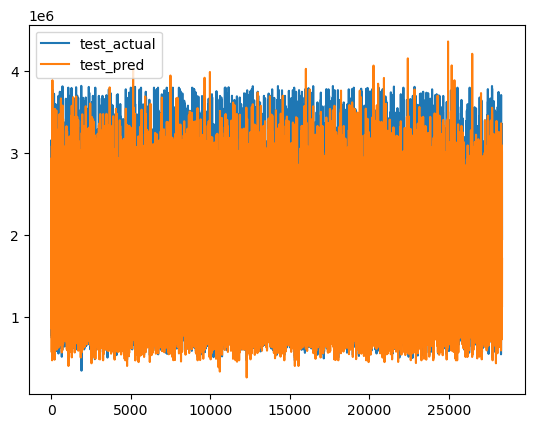

In [56]:

df_pred.plot(legend=True)
     

In [57]:

#calculating model accuracy
(df_pred['test_actual'].sum()-df_pred['test_pred'].sum())/df_pred['test_actual'].sum()

0.026877782330658816

In [63]:
#find rmse score
from sklearn.metrics import mean_squared_error
import math

mse = mean_squared_error(df_pred['test_actual'], df_pred['test_pred'])
rmse = math.sqrt(mse)
print(rmse)

mse = mean_squared_error(df_pred['test_actual'], df_pred['test_pred'])
mae = mean_absolute_error(df_pred['test_actual'], df_pred['test_pred'])
r2 = r2_score(df_pred['test_actual'], df_pred['test_pred'])

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.4f}")

241166.95915166524
Mean Squared Error (MSE): 58161502186.46
Mean Absolute Error (MAE): 166984.56
R^2 Score: 0.8668


# Random Forest


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [32]:
df['Sale Date'] = pd.to_datetime(df['Sale Date'], format='%d/%m/%Y', errors='coerce')
df['Sale Month'] = df['Sale Date'].dt.month
df['Sale Quarter'] = df['Sale Date'].dt.quarter

selected_features = [
    'Area (SQFT)',
    'Postal District',
    'Market Segment',
    'Property Type',
    'Remaining Lease Years',
    'Floor Level',
    'Distance to MRT (km)',
    'Sale Month',
    'Sale Year'
]

In [33]:
target = 'Transacted Price ($)'
df_selected = df[selected_features + [target]].copy()

In [35]:
categorical_cols = ['Postal District', 'Market Segment', 'Property Type', 'Floor Level']
numerical_cols = ['Area (SQFT)', 'Remaining Lease Years', 'Distance to MRT (km)', 'Sale Month', 'Sale Year']

print("\nCategorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)


Categorical columns: ['Postal District', 'Market Segment', 'Property Type', 'Floor Level']
Numerical columns: ['Area (SQFT)', 'Remaining Lease Years', 'Distance to MRT (km)', 'Sale Month', 'Sale Year']


In [36]:
categorical_cols_to_check = [col for col in categorical_cols]
df_selected.dropna(subset=categorical_cols_to_check, inplace=True)

In [37]:
X = df_selected.drop(target, axis=1)
y = df_selected[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=40))
])

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

In [39]:
# 1. MSE - Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
# 2. MAE - Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
# 3. R² - R-squared score
r2 = r2_score(y_test, y_pred)
# 4. Cross-validation score
# cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
# cv_rmse_scores = np.sqrt(-cv_scores)

print("\nModel Evaluation - Requested Metrics:")
print(f"1. Mean Squared Error (MSE): {mse:.2f}")
print(f"2. Mean Absolute Error (MAE): {mae:.2f}")
print(f"3. R² Score: {r2:.4f}")
# print(f"4. Cross-Validation RMSE Scores: {cv_rmse_scores}")
# print(f"   Average CV RMSE: {cv_rmse_scores.mean():.2f}")
# print(f"   Standard Deviation CV RMSE: {cv_rmse_scores.std():.2f}")


Model Evaluation - Requested Metrics:
1. Mean Squared Error (MSE): 4613704228601.37
2. Mean Absolute Error (MAE): 184668.49
3. R² Score: 0.8023
4. Cross-Validation RMSE Scores: [3512659.76726788 1550405.30606498 1012161.08867955 1054965.77148641
 3925132.07937867]
   Average CV RMSE: 2211064.80
   Standard Deviation CV RMSE: 1252404.26



Feature ranking:
1. Area (SQFT) (0.8849)
2. Distance to MRT (km) (0.0180)
3. Floor Level_- (0.0122)
4. Market Segment_Core Central Region (0.0111)
5. Remaining Lease Years (0.0098)
6. Postal District_19 (0.0097)
7. Sale Month (0.0079)
8. Sale Year (0.0071)
9. Market Segment_Outside Central Region (0.0061)
10. Floor Level_01 to 05 (0.0059)


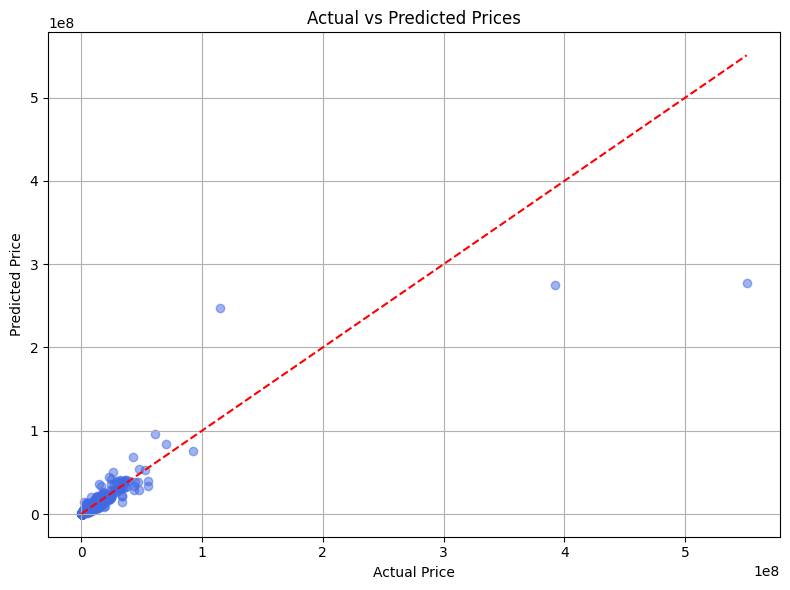

In [40]:
# Feature importance
feature_names = (
    numerical_cols + 
    list(rf_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols))
)
importances = rf_model.named_steps['regressor'].feature_importances_
indices = np.argsort(importances)[::-1]

print("\nFeature ranking:")
for f in range(min(10, len(feature_names))):
    if f < len(indices):
        print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.4f})")


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.tight_layout()
plt.show()


Model Performance After Removing Outliers:
1. Mean Squared Error (MSE): 3496911574.50
2. Mean Absolute Error (MAE): 43790.35
3. R² Score: 0.9960
4. Number of outliers removed: 4412 out of 25670 (17.19%)


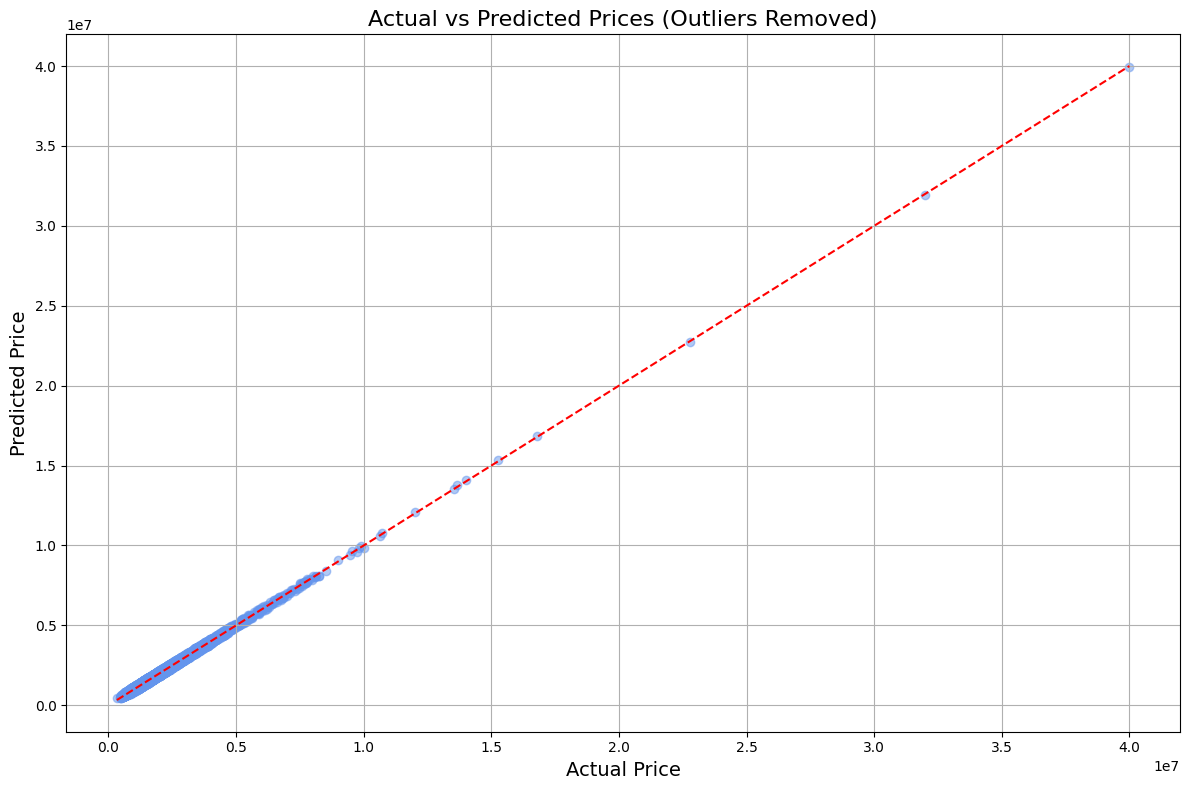

In [41]:
#plot with outliers removed

residuals = y_test - y_pred
Q1 = np.percentile(residuals, 25)
Q3 = np.percentile(residuals, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

non_outlier_mask = (residuals >= lower_bound) & (residuals <= upper_bound)

y_test_no_outliers = y_test[non_outlier_mask]
y_pred_no_outliers = y_pred[non_outlier_mask]

mse_no_outliers = mean_squared_error(y_test_no_outliers, y_pred_no_outliers)
mae_no_outliers = mean_absolute_error(y_test_no_outliers, y_pred_no_outliers)
r2_no_outliers = r2_score(y_test_no_outliers, y_pred_no_outliers)

print(f"Number of outliers removed: {len(y_test) - len(y_test_no_outliers)} out of {len(y_test)} ({(len(y_test) - len(y_test_no_outliers))/len(y_test)*100:.2f}%)")

plt.figure(figsize=(12, 8))
plt.scatter(y_test_no_outliers, y_pred_no_outliers, alpha=0.5, color='cornflowerblue')

min_val = min(y_test_no_outliers.min(), y_pred_no_outliers.min())
max_val = max(y_test_no_outliers.max(), y_pred_no_outliers.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.title('Actual vs Predicted Prices (Outliers Removed)', fontsize=16)
plt.grid(True)
plt.tight_layout()
